<a href="https://colab.research.google.com/github/taha2002/HVDC-ML-POSTER/blob/main/hvdc_fault_detection_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Set Download


In [ ]:
# get data from PG db
import psycopg2, requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

DB_URL = "postgresql://<user_name>:<pg_pass>@<pg_host>/<pg_table_name>?sslmode=require"

# conn = psycopg2.connect(DB_URL)
# query = "SELECT * FROM hvdc_fault_features"
# raw_df = pd.read_sql(query, con=conn)
# conn.close()

In [ ]:
!wget https://huggingface.co/datasets/tahabou/HVDC-SIMULATED-FAULTS-FINAL-COMBINED/resolve/main/raw_data.csv

--2025-04-28 04:07:34--  https://huggingface.co/datasets/tahabou/HVDC-SIMULATED-FAULTS-FINAL-COMBINED/resolve/main/raw_data.csv
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.49, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/4f/0e/4f0eb78c083db2215d626920ade5c681200ef8d4fa9a3df6cbe6edeb135ac315/3e988db80320a86c4b133f09840a5e12a01b1fa9a88b49238ade358939e33f84?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27raw_data.csv%3B+filename%3D%22raw_data.csv%22%3B&response-content-type=text%2Fcsv&Expires=1745816854&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTgxNjg1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzRmLzBlLzRmMGViNzhjMDgzZGIyMjE1ZDYyNjkyMGFkZTVjNjgxMjAwZWY4ZDRmYTlhM2RmNmNiZTZlZGViMTM1YWMzMTUvM2U5ODhkYjgwMzIwYTg2YzRiMTMzZjA5ODQwYTVlMTJhMDFiMWZ

## Data loading

In [ ]:
import pandas as pd
raw_df = pd.read_csv("raw_data.csv")
raw_df.head(0)

,filename,run_number,fault_type,fault_time,fault_duration,fault_resistance,features,created_at


## Data cleaning & exploration

In [ ]:
import ast

def parse_json(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing features: {e}, Input: {x}")
        return {}

features_df = raw_df['features'].apply(parse_json).apply(pd.Series)

# Concatenate the extracted features with the original DataFrame
df = pd.concat([raw_df.drop(columns=["features"]), features_df], axis=1)
df.head(0)

,filename,run_number,fault_type,fault_time,fault_duration,fault_resistance,created_at,Inverter_AMin_max,Inverter_AMin_min,Inverter_AMin_rms,...,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_energy,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_median,InverterControlSignals_ControlMode_0_blocked1_current2_voltage3_kurtosis,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_kurtosis,InverterControlSignals_ControlMode_0_blocked1_current2_voltage3_dominant_freq,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_dominant_freq,InverterControlSignals_ControlMode_0_blocked1_current2_voltage3_zero_crossings,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_zero_crossings,InverterControlSignals_ControlMode_0_blocked1_current2_voltage3_spectral_centroid,RectifierControlSignals_ControlMode_0_blocked1_current2_voltage_spectral_centroid


In [ ]:
#Removing Unwanted Columns

columns_has = ['FaultSignals_I','alpha_ord','gamma_mean','ControlMode','Valve','RectifierControlSignals_IdIdref_lim_pu__2','RectifierValveSignals_alpha_ord_deg','InverterControlSignals_IdIdref_lim_pu__2', 'InverterControlSignals_alpha_ord_deg','InverterControlSignals_VdLVd_ref_pu__2','Inverter_AMin','Inverter_LowACVolt','Rectifier_LowACVolt','Rectifier_ForcedAlpha']
columns_has += [
    '_rms','_skew',
    '_peaks','_range','_median','_kurtosis','_dominant_freq',
    '_zero_crossings','_spectral_centroid'
]

columns_to_remove = ['filename', 'run_number', 'fault_time','fault_duration', 'fault_deration', 'fault_resistance', 'created_at'] +  [col for col in df.columns if any(text in col for text in columns_has)]
df = df.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
# dictionary to map old column names to new, shorter names
base_rename_dict = {
    'InverterACSignals_Vabc_pu__1': 'Va_I',
    'InverterACSignals_Vabc_pu__2': 'Vb_I',
    'InverterACSignals_Vabc_pu__3': 'Vc_I',
    'RectifierACSignals_Vabc_pu__1': 'Va_R',
    'RectifierACSignals_Vabc_pu__2': 'Vb_R',
    'RectifierACSignals_Vabc_pu__3': 'Vc_R',
    'InverterACSignals_Iabc_pu_100MVA__1': 'Ia_I',
    'InverterACSignals_Iabc_pu_100MVA__2': 'Ib_I',
    'InverterACSignals_Iabc_pu_100MVA__3': 'Ic_I',
    'RectifierACSignals_Iabc_pu_100MVA__1': 'Ia_R',
    'RectifierACSignals_Iabc_pu_100MVA__2': 'Ib_R',
    'RectifierACSignals_Iabc_pu_100MVA__3': 'Ic_R',
    'RectifierControlSignals_VdL_pu': 'Vdl_R',
    'InverterControlSignals_VdLVd_ref_pu__1': 'Vdl_I',
    'InverterControlSignals_IdIdref_lim_pu__1': 'Id_I',
    'RectifierControlSignals_IdIdref_lim_pu__1': 'Id_R',
    'fault_type': 'fault_type'
}

def rename_columns(col_name):
    for old_base, new_base in base_rename_dict.items():
        if col_name.startswith(old_base):
            suffix = col_name.replace(old_base, '')
            return new_base + suffix
    return col_name

df.columns = [rename_columns(col) for col in df.columns]

print(df.columns.tolist())

['fault_type', 'Va_I_max', 'Va_I_min', 'Va_I_std', 'Vb_I_max', 'Vb_I_min', 'Vb_I_std', 'Vc_I_max', 'Vc_I_min', 'Vc_I_std', 'Va_I_mean', 'Vb_I_mean', 'Vc_I_mean', 'Va_R_max', 'Va_R_min', 'Va_R_std', 'Vb_R_max', 'Vb_R_min', 'Vb_R_std', 'Vc_R_max', 'Vc_R_min', 'Vc_R_std', 'Va_R_mean', 'Vb_R_mean', 'Vc_R_mean', 'Va_I_energy', 'Vb_I_energy', 'Vc_I_energy', 'Vdl_R__max', 'Vdl_R__min', 'Vdl_R__std', 'Va_R_energy', 'Vb_R_energy', 'Vc_R_energy', 'Vdl_R__mean', 'Vdl_R__energy', 'Ia_I_max', 'Ia_I_min', 'Ia_I_std', 'Ib_I_max', 'Ib_I_min', 'Ib_I_std', 'Ic_I_max', 'Ic_I_min', 'Ic_I_std', 'Ia_I_mean', 'Ib_I_mean', 'Ic_I_mean', 'Ia_R_max', 'Ia_R_min', 'Ia_R_std', 'Ib_R_max', 'Ib_R_min', 'Ib_R_std', 'Ic_R_max', 'Ic_R_min', 'Ic_R_std', 'Ia_R_mean', 'Ib_R_mean', 'Ic_R_mean', 'Ia_I_energy', 'Ib_I_energy', 'Ic_I_energy', 'Vdl_I_max', 'Vdl_I_min', 'Vdl_I_std', 'Vdl_I_mean', 'Ia_R_energy', 'Ib_R_energy', 'Ic_R_energy', 'Id_I_max', 'Id_I_min', 'Id_I_std', 'Id_I_mean', 'Vdl_I_energy', 'Id_R_max', 'Id_R_min', '

##data visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Examine data types
print(df.info())

# 2. Summarize numerical features
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23146 entries, 0 to 23145
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fault_type     21020 non-null  object 
 1   Va_I_max       23146 non-null  float64
 2   Va_I_min       23146 non-null  float64
 3   Va_I_std       23146 non-null  float64
 4   Vb_I_max       23146 non-null  float64
 5   Vb_I_min       23146 non-null  float64
 6   Vb_I_std       23146 non-null  float64
 7   Vc_I_max       23146 non-null  float64
 8   Vc_I_min       23146 non-null  float64
 9   Vc_I_std       23146 non-null  float64
 10  Va_I_mean      23146 non-null  float64
 11  Vb_I_mean      23146 non-null  float64
 12  Vc_I_mean      23146 non-null  float64
 13  Va_R_max       23146 non-null  float64
 14  Va_R_min       23146 non-null  float64
 15  Va_R_std       23146 non-null  float64
 16  Vb_R_max       23146 non-null  float64
 17  Vb_R_min       23146 non-null  float64
 18  Vb_R_s

fault_type     2126
Va_I_max          0
Va_I_min          0
Va_I_std          0
Vb_I_max          0
               ... 
Id_R_min          0
Id_R_std          0
Id_R_mean         0
Id_I_energy       0
Id_R_energy       0
Length: 81, dtype: int64


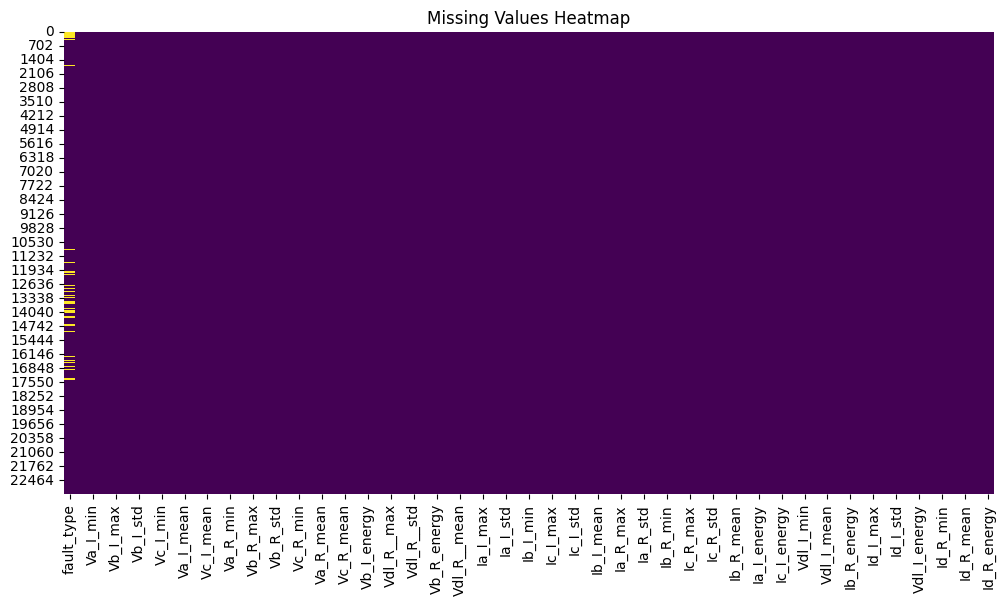

In [ ]:
# 3. Check for missing values
print(df.isnull().sum())
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
df['fault_type'].fillna("no_fault", inplace=True)

##Analyze the target variable

fault_type
no_fault    2126
DC10        2068
DC50        2068
DC25        2063
AG          1983
DC90        1961
CG          1912
AB          1908
DC75        1859
BG          1761
AC          1721
BC          1716
Name: count, dtype: int64


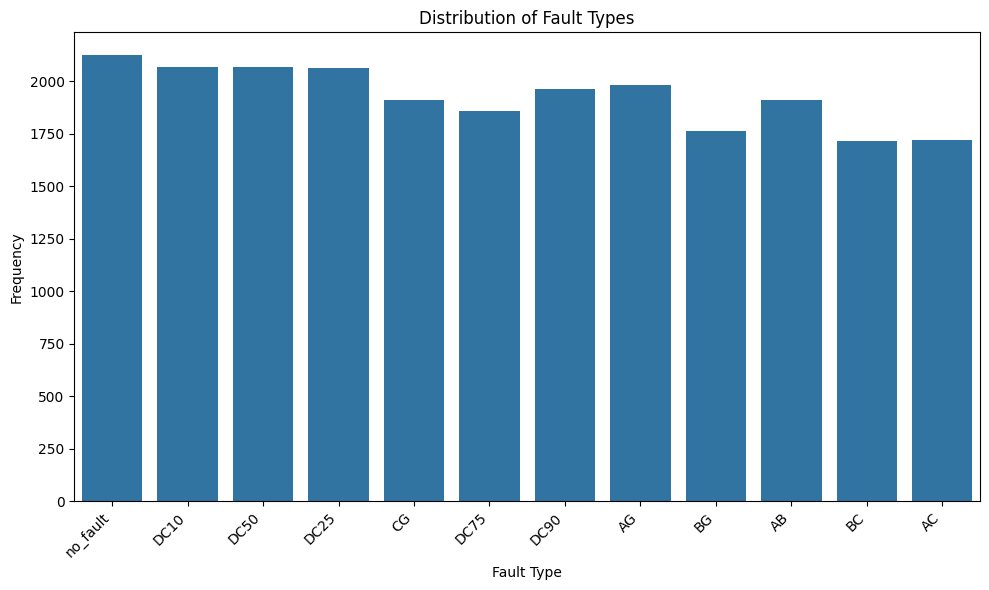

In [ ]:
print(df['fault_type'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='fault_type', data=df)
plt.title('Distribution of Fault Types')
plt.xlabel('Fault Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Preprocessing
# Encode the target variable 'fault_type'
le = LabelEncoder()
df['fault_type_encoded'] = le.fit_transform(df['fault_type'])

# Separate features (X) and target (y)
X = df.drop(['fault_type', 'fault_type_encoded'], axis=1)
y = df['fault_type_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model training

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize models with simplified parameters and adjustments to prevent overfitting
models = {
    "Logistic Regression": LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=20, learning_rate=0.01, max_depth=2),
    'Neural Network': MLPClassifier(),
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    report = classification_report(y_test, y_pred, zero_division=0)

    results[model_name] = {"model": model, "accuracy": accuracy, "report": report}

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(report)
    print("-" * 30)

Training Logistic Regression...
Logistic Regression Accuracy: 0.8104
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       383
           1       1.00      0.95      0.97       342
           2       0.91      0.82      0.86       404
           3       1.00      0.96      0.98       346
           4       0.93      0.76      0.84       357
           5       0.97      0.82      0.89       399
           6       0.74      0.85      0.79       389
           7       0.72      0.87      0.79       437
           8       0.00      0.00      0.00       389
           9       0.51      0.91      0.66       389
          10       0.99      0.86      0.92       396
          11       0.65      1.00      0.78       399

    accuracy                           0.81      4630
   macro avg       0.79      0.81      0.79      4630
weighted avg       0.78      0.81      0.78      4630

------------------------------
Training Support Vector Machine..

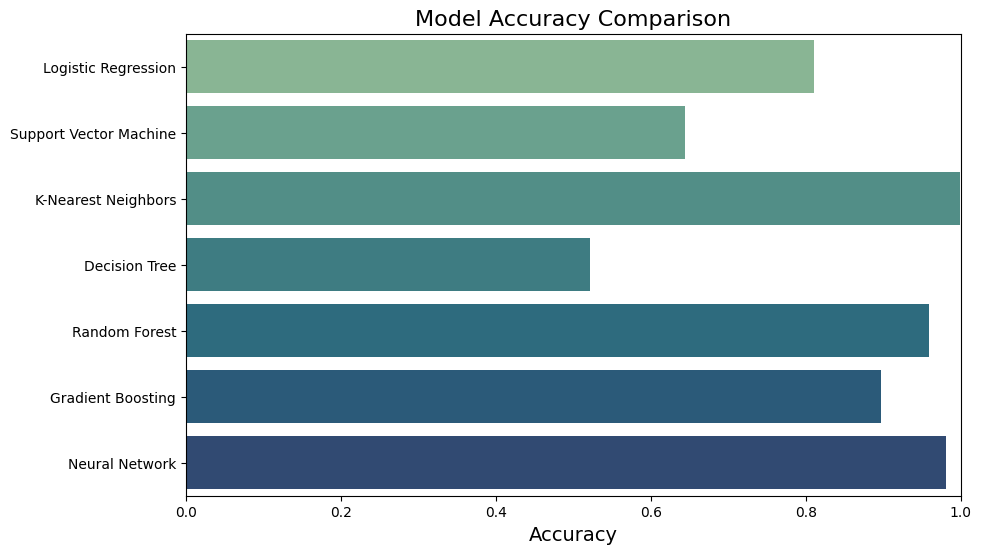

In [ ]:
# Accuracy Comparison Plot
accuracies = [result["accuracy"] for result in results.values()]
model_names = list(models.keys())

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette="crest")
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.xlim(0, 1)
plt.show()

##Confusion matrices for all the models

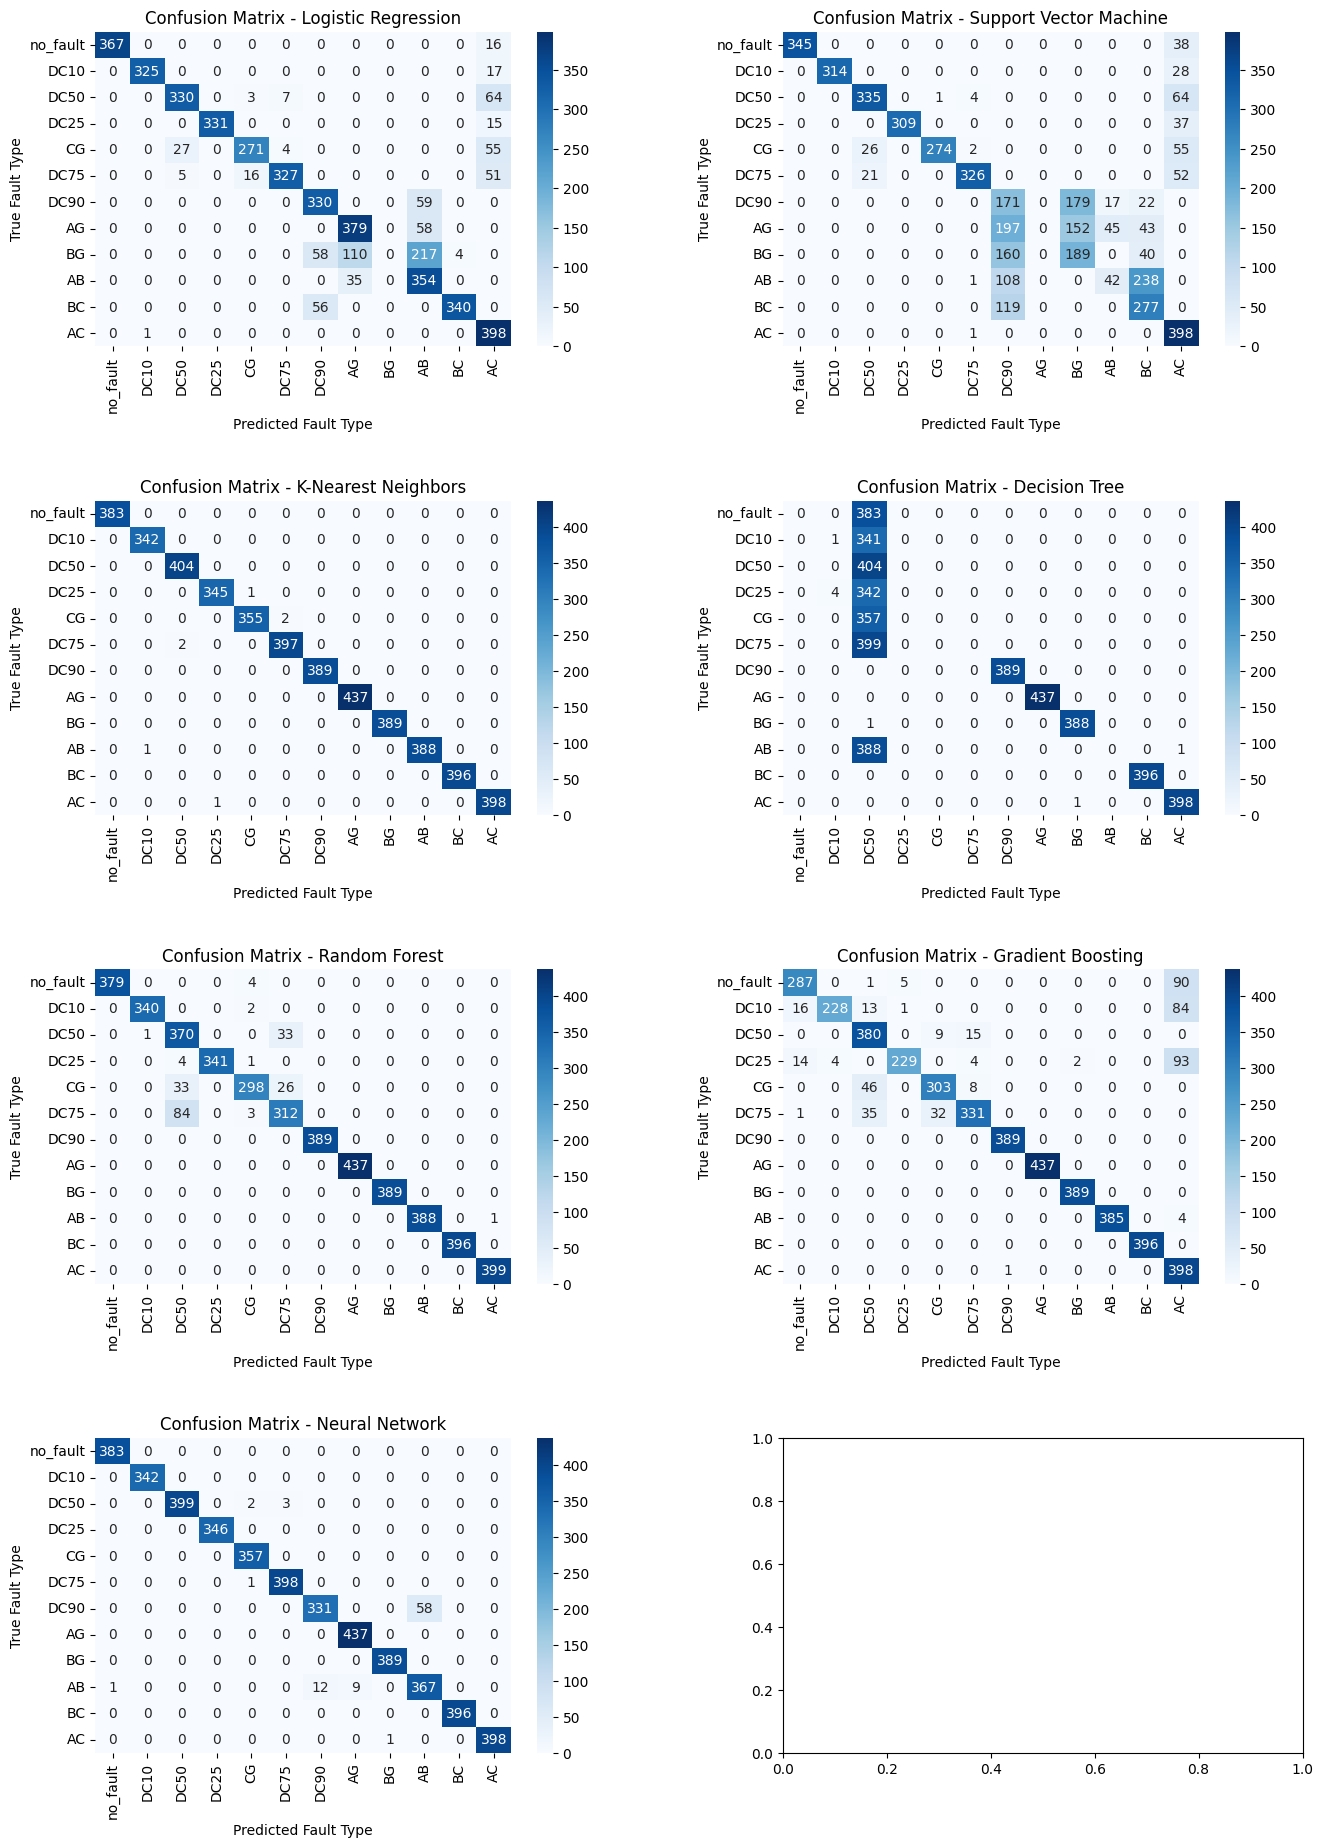

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


fault_types = df['fault_type'].unique()

# Create a figure and subplots to display confusion matrices for each model
num_models = len(models)
fig, axes = plt.subplots(num_models // 2 + num_models % 2, 2, figsize=(15, 5 * (num_models // 2 + num_models % 2)))
fig.tight_layout(pad=9.0)  # Adjust padding for better layout

# Loop through models to create confusion matrices
model_index = 0
for model_name, model_data in results.items():
    # Get predictions for the current model
    y_pred = model_data['model'].predict(X_test)

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Determine subplot position
    row = model_index // 2
    col = model_index % 2
    ax = axes[row, col] if num_models > 2 else axes[model_index]

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=fault_types, yticklabels=fault_types, ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted Fault Type")
    ax.set_ylabel("True Fault Type")

    model_index += 1

plt.show()

##Visualizing Feature Importance

highlights key features driving model predictions

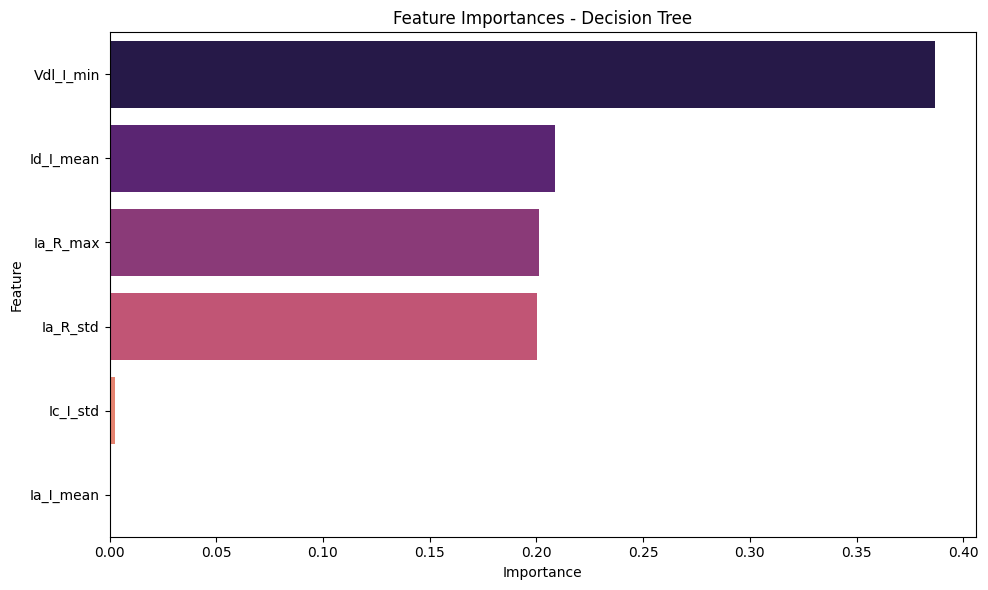

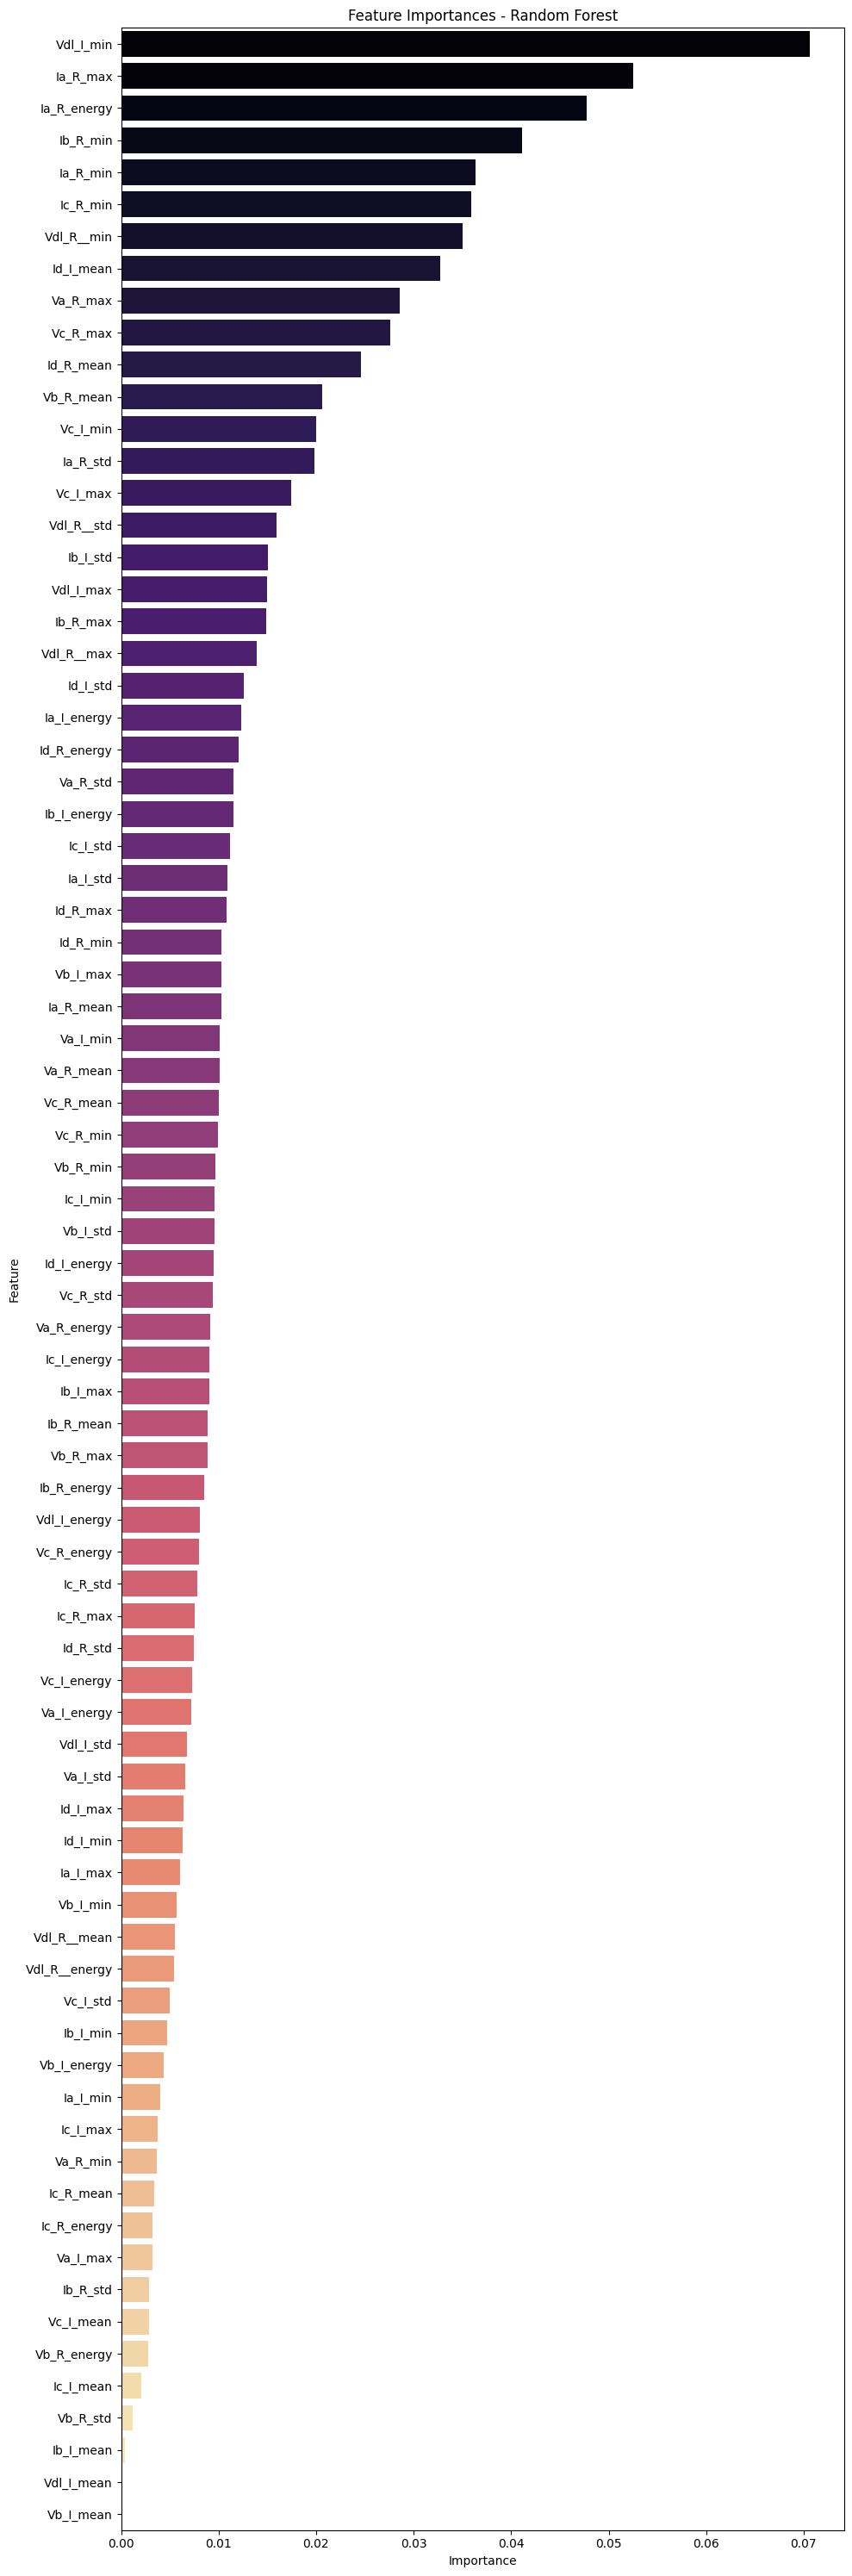

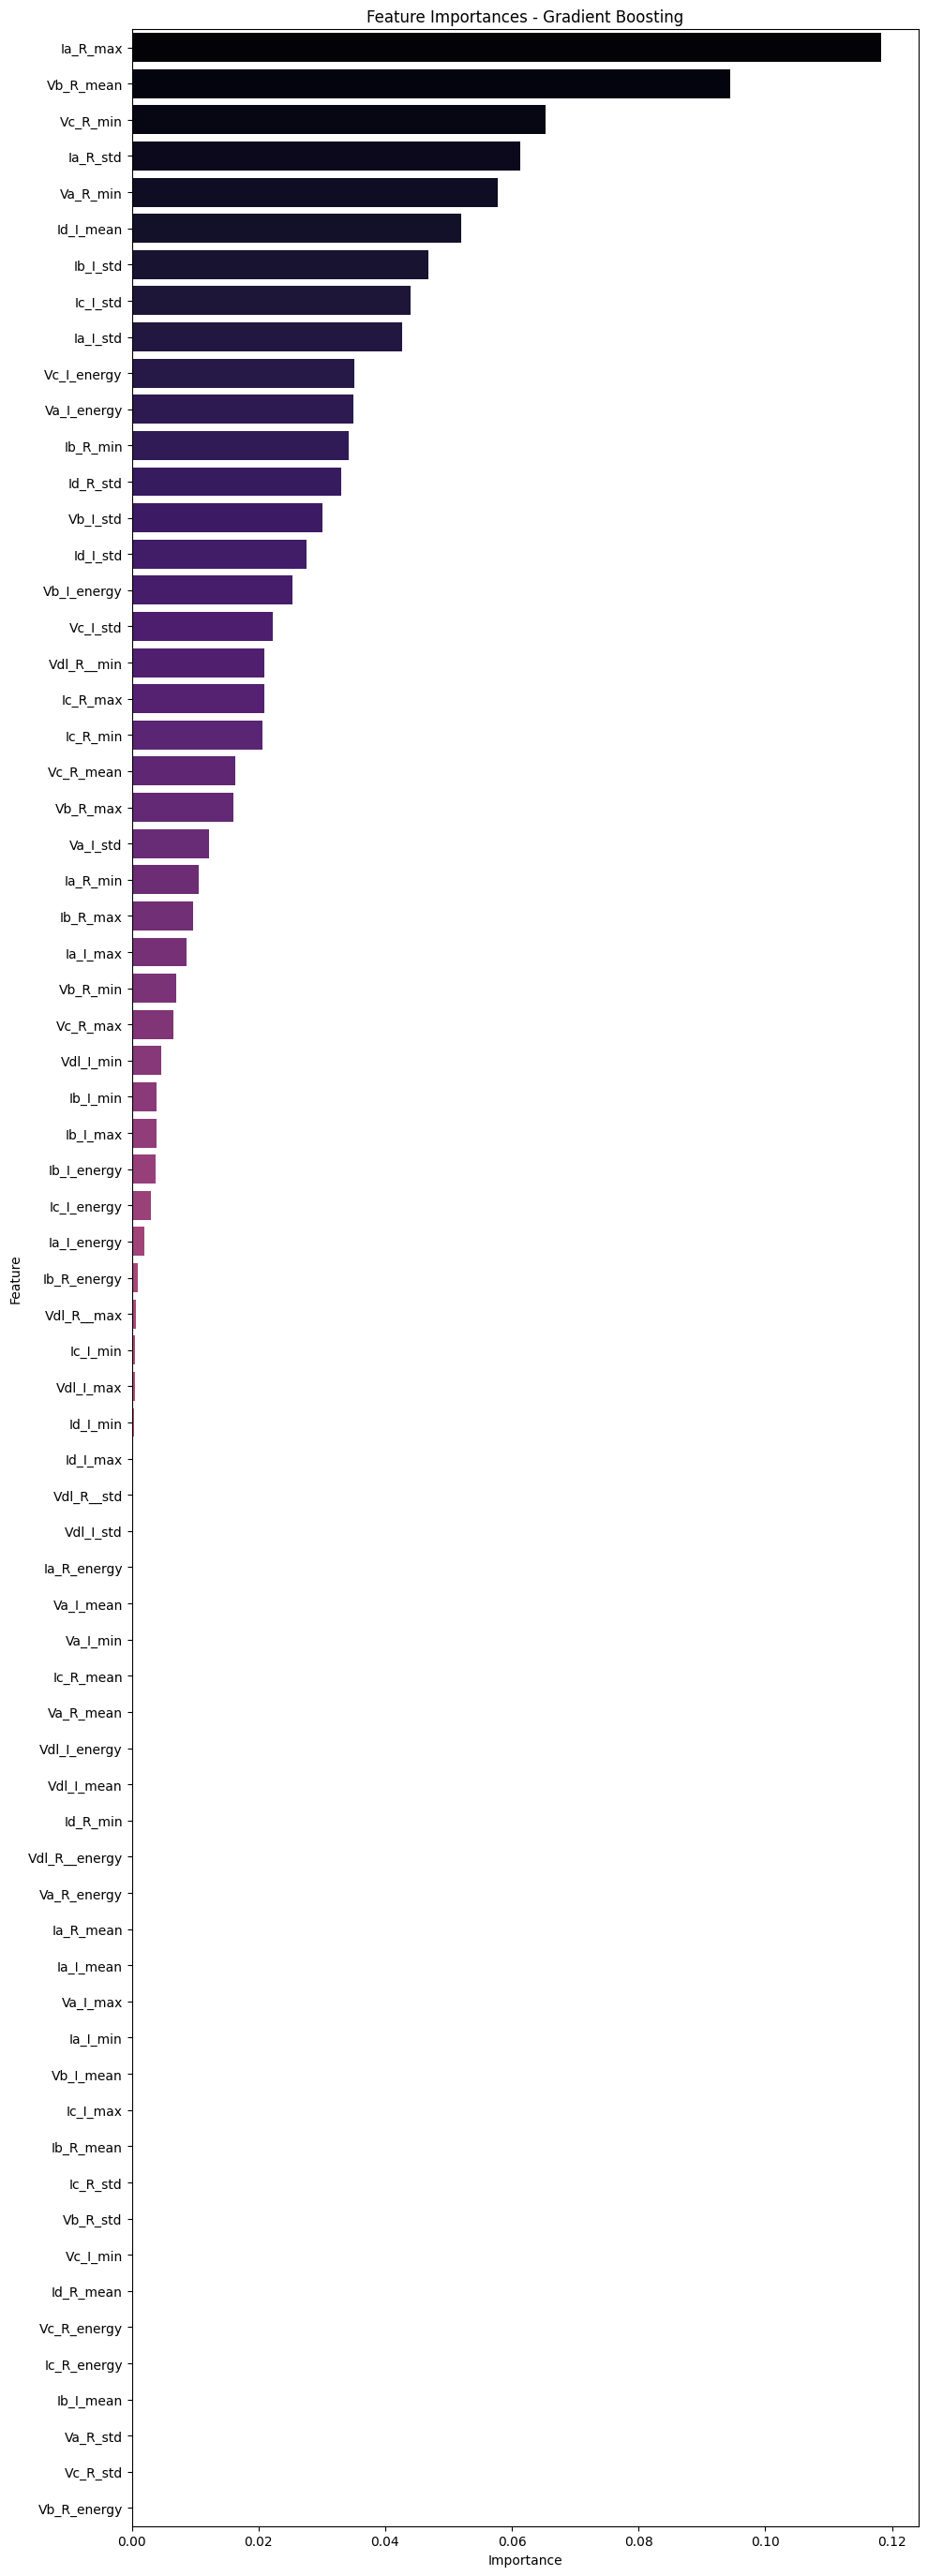

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, data in results.items():
    model = data["model"]

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(len(importances))]

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Filter out features with zero importance
        importance_df = importance_df[importance_df['Importance'] > 0]

        # Adjust figsize dynamically with a minimum and maximum height
        num_features = len(importance_df)
        fig_height = max(6, min(30, num_features * 0.4))  # Adjust factors as needed
        plt.figure(figsize=(10, fig_height))

        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
        plt.title(f'Feature Importances - {model_name}')
        plt.tight_layout()
        plt.show()

##Model Tuning and Training using GridSearchCV for best accurecy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'C': [0.01, 0.1],
            'penalty': ['l1', 'l2']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 5],
            'min_samples_split': [2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [10, 20],
            'learning_rate': [0.01, 0.1],
            'max_depth': [2, 3]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1],
            'kernel': ['linear', 'rbf']
        }
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(32,), (64,)],
            'alpha': [0.01, 0.1]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }
}

results_ = {}

for model_name, mp in model_params.items():
    print(f"\nTuning and training {model_name}...")

    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)

    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    results_[model_name] = {
        "best_params": clf.best_params_,
        "accuracy": accuracy,
        "report": report
    }

    print(f"Best Parameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(report)
    print("-" * 30)



Tuning and training Logistic Regression...
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.8104
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       383
           1       1.00      0.95      0.97       342
           2       0.91      0.82      0.86       404
           3       1.00      0.96      0.98       346
           4       0.93      0.76      0.84       357
           5       0.97      0.82      0.89       399
           6       0.74      0.85      0.79       389
           7       0.72      0.87      0.79       437
           8       0.00      0.00      0.00       389
           9       0.51      0.91      0.66       389
          10       0.99      0.86      0.92       396
          11       0.65      1.00      0.78       399

    accuracy                           0.81      4630
   macro avg       0.79      0.81      0.79      4630
weighted avg       0.78      0.81      0.78      4630

---------------------------